# Fault Detection in Wastewater Treatment Plants: Application of Autoencoders with Streaming Data

### Notebook developed to implement the fault detection system described in the paper *Fault Detection in Wastewater Treatment Plants: Application of Autoencoders with Streaming Data*

### Data obtained with the BSM2 simulator.

In [ ]:
# Load libraries needed by the project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timezone
import statsmodels.api as sm
import scipy.stats as st
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.models import load_model
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load dataset
df1 = pd.read_excel('/content/drive/MyDrive/Autoencoder/datasets/DO_falha3.xlsx')

df_normal = pd.read_csv('/content/drive/MyDrive/Autoencoder/datasets/sensor_DO_normal.csv', sep=';')

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5]),
 <a list of 8 Text major ticklabel objects>)

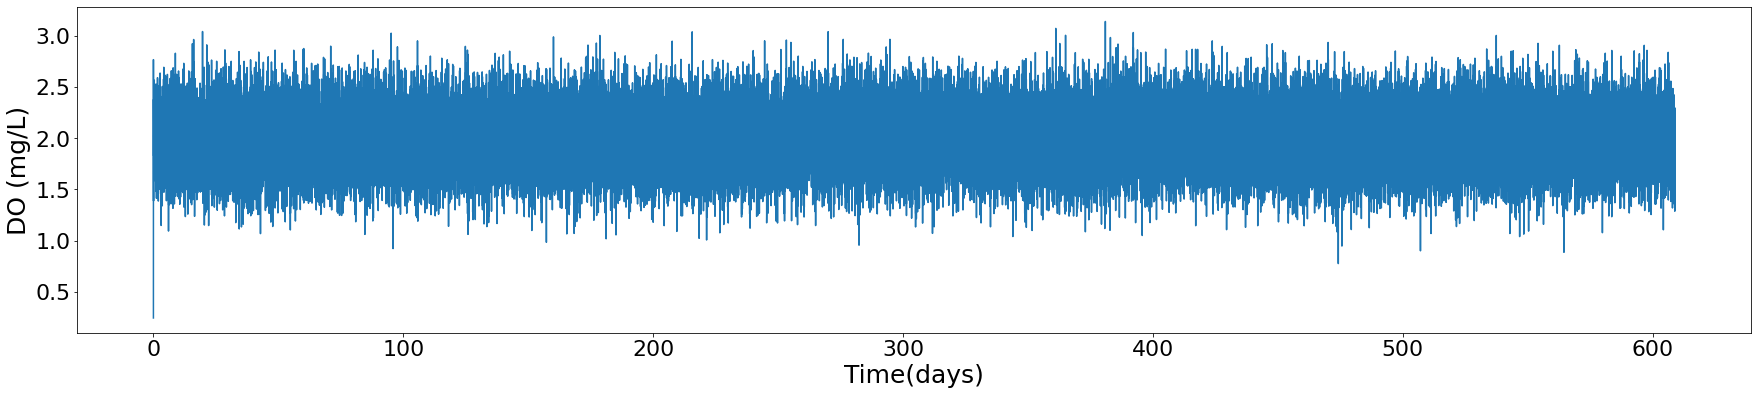

In [ ]:
# fault-free dataset for autoencoder training
plt.figure(figsize = (30, 6))
#p = sns.lineplot(x="time", y="value", data=df1[0:8640])
p = sns.lineplot(x="time", y="value", data=df_normal)
plt.xlabel('Time(days)', fontsize=25)
plt.ylabel('DO (mg/L)', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

In [ ]:
# Create dataframe with dates and values of DO levels.
df = pd.DataFrame()
df['Date'] = df1.time
df['value'] = df1.value

In [ ]:
df_normal1 = pd.DataFrame()
df_normal1['Date'] = df_normal.time
df_normal1['value'] = df_normal.value

In [ ]:
# Adjust stuck anomaly value
# Check indices of anomalous samples
df1.loc[df1['time'] == 95]

# Adjust Drift Values

index1 = df.index[df['Date']>=40].tolist()
index2 = df.index[df['Date']<=43].tolist()
max(index2)
min(index1)
# print(df.loc[df['Date'] == 58])
# print(df.loc[df['Date'] == 62])
for i in range(1440,1632):
  df.loc[i,'value'] = df.loc[i,'value']+0.5

In [ ]:
# Adjust Drift Values

#index1 = df.index[df['Date']>=40].tolist()
#index2 = df.index[df['Date']<=43].tolist()
#max(index2)
#min(index1)
for i in range(5568,5952):
  df.loc[i,'value'] = df.loc[i,'value']-27

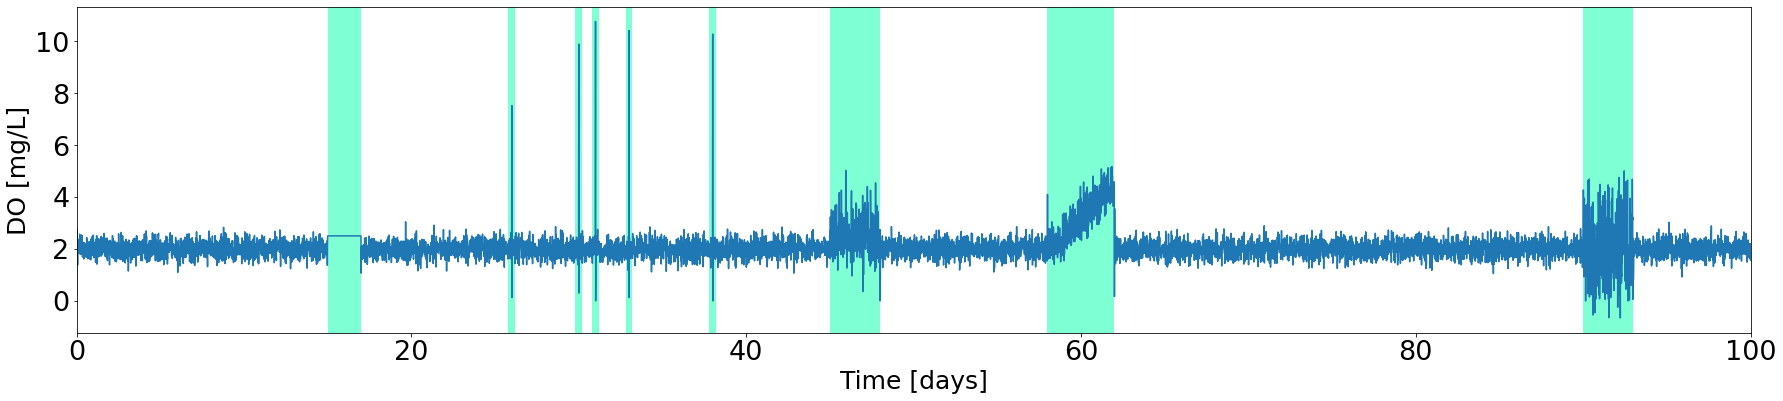

In [ ]:
# Graph of the time series and implemented failures 
plt.figure(figsize = (30, 6))
#p = sns.lineplot(x="time", y="value", data=df1[0:8640])
p = sns.lineplot(x="Date", y="value", data=df[0:10000])
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.xlim(0,100)

p.axvspan(58, 62, facecolor='aquamarine')
p.axvspan(15, 17, facecolor='aquamarine')

p.axvspan(25.8, 26.2, facecolor='aquamarine')
p.axvspan(29.8, 30.2, facecolor='aquamarine')
p.axvspan(30.8, 31.2, facecolor='aquamarine')
p.axvspan(32.8, 33.2, facecolor='aquamarine')
p.axvspan(37.8, 38.2, facecolor='aquamarine')



#p.axvspan(26, 38, facecolor='aquamarine')
p.axvspan(45, 48, facecolor='aquamarine')
p.axvspan(90, 93, facecolor='aquamarine')

plt.savefig('/content/drive/MyDrive/Autoencoder/falhas_caso3_25_07.pdf', dpi=500, format='pdf', bbox_inches='tight')

## Data processing
### Split dataset into training and testing sets

In [ ]:
df1_treino = df_normal1.iloc[0:10000,:]
df1_teste = df.iloc[0:10000,:]

In [ ]:
df1_treino.to_csv('df_treino_bsm2.csv')

In [ ]:
# Using time as an index
df1_treino = pd.read_csv('df_treino_bsm2.csv', parse_dates=True, index_col="Date")

In [ ]:
# Delete column created with old indexes
df1_treino = df1_treino.drop(columns=['Unnamed: 0'])

In [ ]:
df1_treino.head()

,value
Date,
0.000000,0.244862
0.010417,2.766354
0.020833,1.801208
0.031250,2.127110
0.041667,1.963473


(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5]),
 <a list of 8 Text major ticklabel objects>)

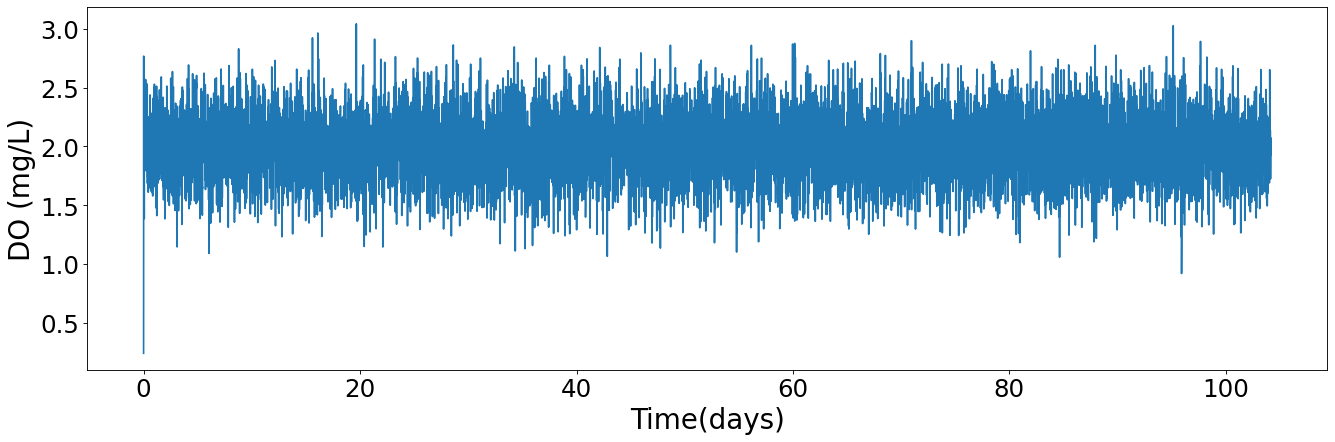

In [ ]:
# Graph
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

#plt.figure(figsize = (15, 6))
p = sns.lineplot(x="Date", y="value", data=df1_treino)

#df1_treino = df1.iloc[9500:15361,:]

# plt.scatter(df_subset.id2.iloc[0:420],df_subset.value.iloc[0:420], color="r")
# plt.plot(df1_teste.id1.iloc[800:1600], df1_teste.value.iloc[800:1600])

plt.xlabel('Time(days)', fontsize=25)
plt.ylabel('DO (mg/L)', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

#plt.savefig('/content/drive/MyDrive/Autoencoder/DO_normal_25_05.pdf', dpi=500, format='pdf', bbox_inches='tight')

## Implementing Autoencoders

In [ ]:
# Normalizing the datas
training1_mean = df1_treino.mean()
training1_std = df1_treino.std()
df1_training_value = (df1_treino - training1_mean) / training1_std
print("Number of training samples:", len(df1_training_value))  

Number of training samples: 10000


In [ ]:
# Create the window that will go through the sequence
TIME_STEPS = 96

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df1_training_value.values) 

## Creating the model

In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 32)            256       
                                                                 
 dropout (Dropout)           (None, 48, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 48, 16)           1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 48, 16)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 96, 32)           3616      
 ranspose)                                              

In [ ]:
#Training the model
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
    ],
)

In [ ]:
model.save("/content/drive/MyDrive/Autoencoder/modelos/model_autoencoder_conv1.h5")

In [ ]:
model = load_model('/content/drive/MyDrive/Autoencoder/modelos/model_autoencoder_conv1.h5')

Reconstruction error threshold:  0.2427567236143282


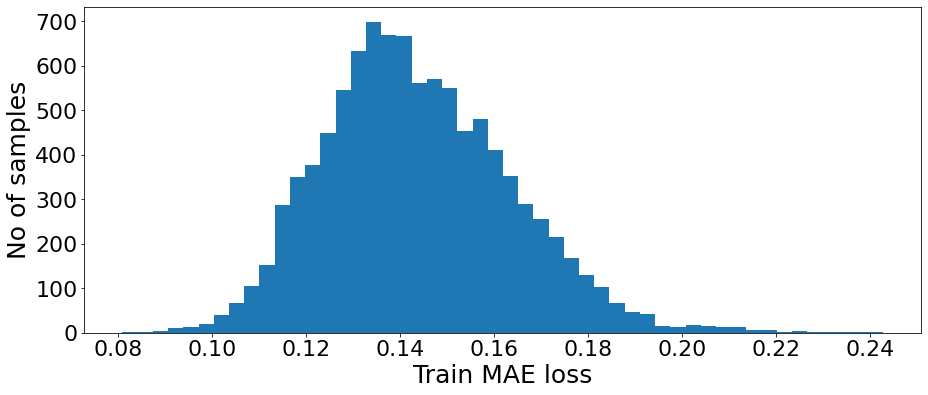

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
plt.figure(figsize = (15, 6))
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss", fontsize=25)
plt.ylabel("No of samples", fontsize=25)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


#plt.savefig('/content/drive/MyDrive/Autoencoder/fig_BSM2_caso_3/reconstucao_erro_conv3.pdf', dpi=500, format='pdf', bbox_inches='tight')
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

plt.show()

In [ ]:
threshold = 0.222306 # The thresholds must be the same as the first model (case1)

## Tests

In [ ]:
df1_teste.to_csv('df_teste_bsm2.csv')
# Passar o tempo como índice
df1_teste = pd.read_csv('df_teste_bsm2.csv', parse_dates=True, index_col="Date")
# Eliminar coluna criada com índices antigos
df1_teste = df1_teste.drop(columns=['Unnamed: 0'])

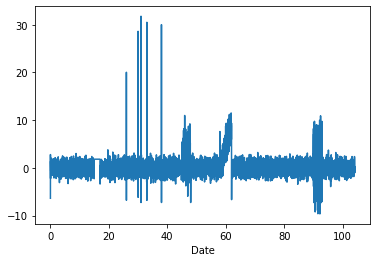

Test input shape:  (9904, 96, 1)


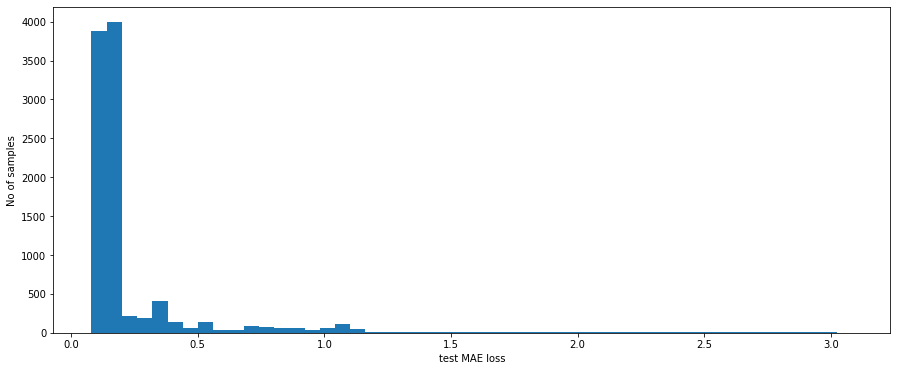

Number of anomaly samples:  1924
Indices of anomaly samples:  (array([1365, 1367, 1369, ..., 8922, 8923, 9144]),)


In [ ]:
df_test_value = (df1_teste - training1_mean) / training1_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
plt.figure(figsize = (15, 6))
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [ ]:
# Anomalous values
df_subset = df1_teste.iloc[anomalous_data_indices] # Valores anomalos

In [ ]:
# Create column with indexes to facilitate plots
df_subset['id2'] = df_subset.index
df1_teste['id1'] = df1_teste.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Results

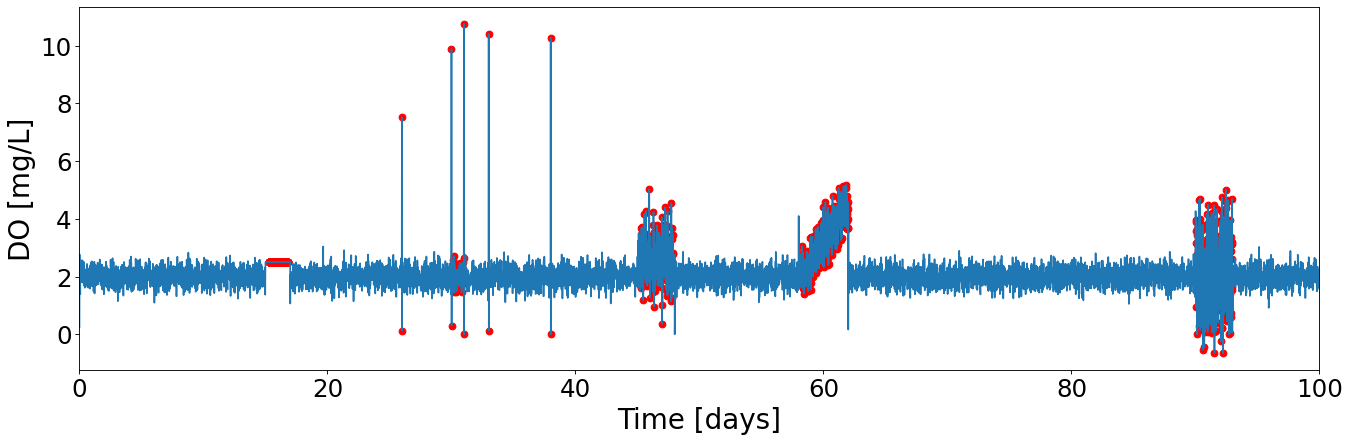

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0,100)
plt.scatter(df_subset.id2,df_subset.value, color="r")
plt.plot(df1_teste.id1, df1_teste.value)

plt.savefig('/content/drive/MyDrive/Autoencoder/resultado_total_conv3.pdf', dpi=500, format='pdf', bbox_inches='tight')

## Graph with individual results

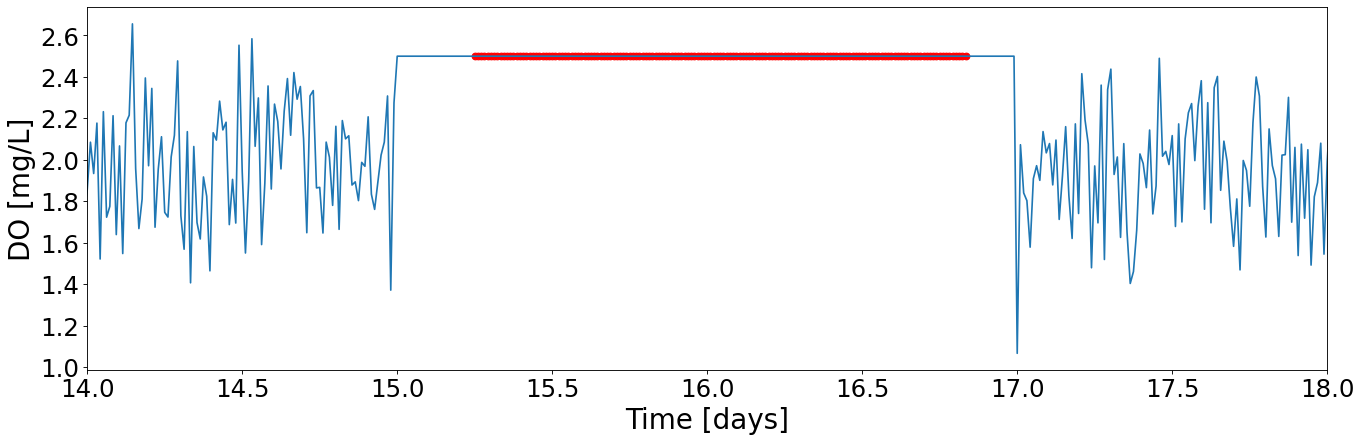

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[0:153],df_subset.value.iloc[0:153], color="r")
plt.plot(df1_teste.id1.iloc[1340:1732], df1_teste.value.iloc[1340:1732])
plt.xlim(14,18)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_3/resultado_stuck3_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures

# Identify the first failure detection time
#df_subset.loc[df_subset['id2'] >= 15].head(3) # 15.250000

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 15].head(1) #15.0

# Do the math for the fraction that equals 15 min.
((15.250000 - 15.0)*15)/0.010416666666666666 # 360.0

360.0

In [ ]:
# Count number of anomalies
cont = 0
for i in df_subset['id2']:
  if i >= 15 and i <= 17:
    cont = cont+1
print('Nº de anomalias para a falha Stuck: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 15 and i <= 17:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Stuck: ',cont2)

Nº de anomalias para a falha Stuck:  153
Nº de amostras totais para a falha Stuck:  193


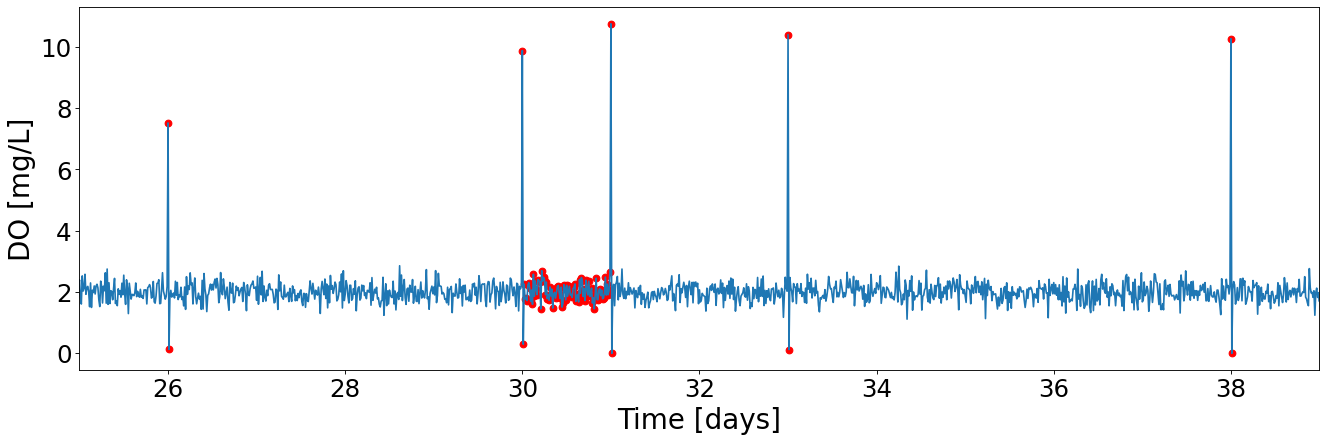

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[153:257],df_subset.value.iloc[153:257], color="r")
plt.plot(df1_teste.id1.iloc[2396:3748], df1_teste.value.iloc[2396:3748])
plt.xlim(25,39)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_3/resultado_spike3_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Count number of anomalies
cont = 0
for i in df_subset['id2']:
  if i >= 26 and i <= 38:
    cont = cont+1
print('Nº de anomalias para a falha Stuck: ',cont)

Nº de anomalias para a falha Stuck:  103


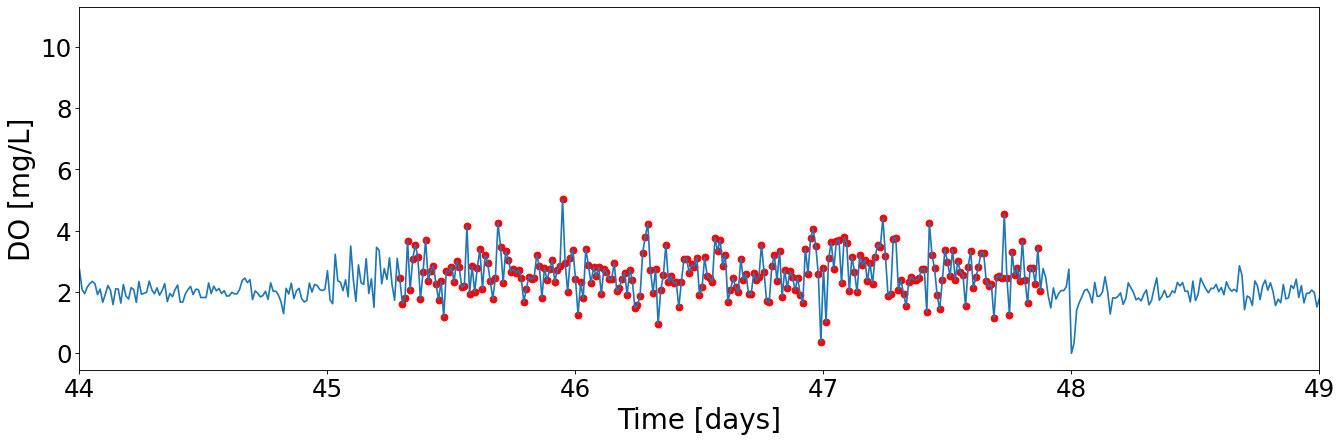

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[250:506],df_subset.value.iloc[250:506], color="r")
plt.plot(df1_teste.id1.iloc[4220:4708], df1_teste.value.iloc[4220:4708])
plt.xlim(44,49)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_3/resultado_bias3_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures

# Identify the first failure detection time
#df_subset.loc[df_subset['id2'] >= 45].head(1) # 45.291667

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 45].head(1) #45.0

# Do the math for the fraction that equals 15 min.
((45.291667 - 45.0)*15)/0.010416666666666666 # 420.0004799999954

420.0004799999954

In [ ]:
# Count number of anomalies
cont = 0
for i in df_subset['id2']:
  if i >= 45 and i <= 48:
    cont = cont + 1
print('Nº de anomalias para a falha Degradation: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 45 and i <= 48:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Degradation: ',cont2)

Nº de anomalias para a falha Degradation:  249
Nº de amostras totais para a falha Degradation:  289


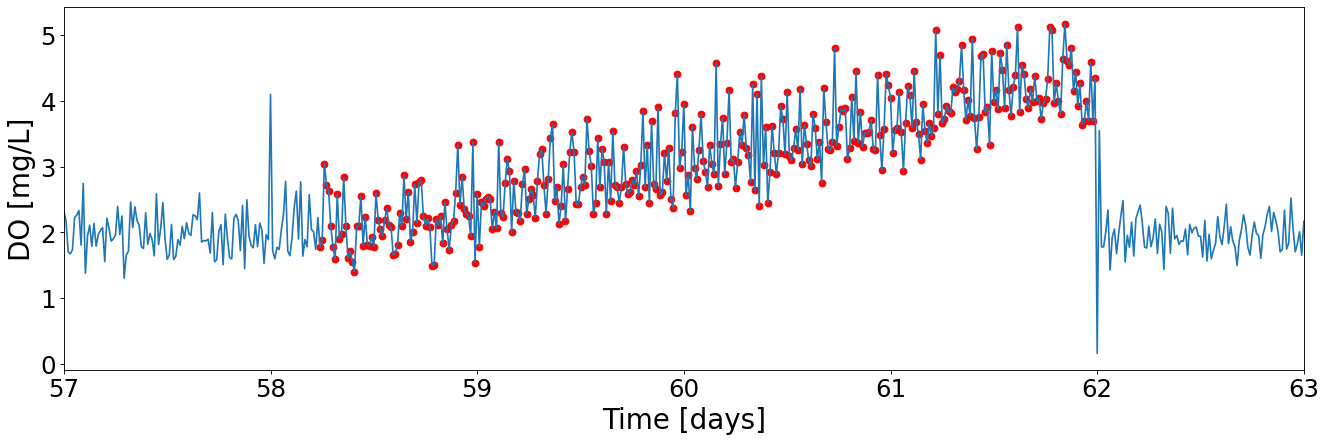

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[506:867],df_subset.value.iloc[506:867], color="r")
plt.plot(df1_teste.id1.iloc[5468:6052], df1_teste.value.iloc[5468:6052])
plt.xlim(57,63)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_3/resultado_drift3_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures

# Identify the first failure detection time
#df_subset.loc[df_subset['id2'] >= 58].head(1) # 58.239583

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 58].head(1) #58.0

# Do the math for the fraction that equals 15 min.
((58.239583 - 58.0)*15)/0.010416666666666666 # 344.9995200000046

344.9995200000046

In [ ]:
# Count number of anomalies
cont = 0
for i in df_subset['id2']:
  if i >= 58 and i <= 62:
    cont = cont + 1
print('Nº de anomalias para a falha Degradation: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 58 and i <= 62:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Degradation: ',cont2)

Nº de anomalias para a falha Degradation:  361
Nº de amostras totais para a falha Degradation:  385


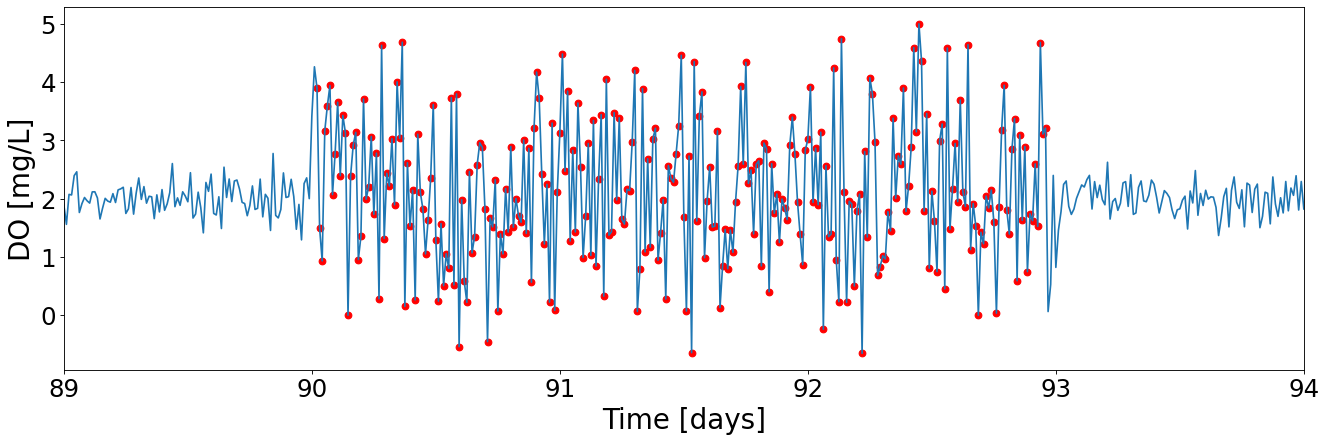

In [ ]:
# Degradation
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[867:1150],df_subset.value.iloc[867:1150], color="r")
plt.plot(df1_teste.id1.iloc[8540:9028], df1_teste.value.iloc[8540:9028])
plt.xlim(89,94)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_3/resultado_PD3_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures

# Identify the first failure detection time
#df_subset.loc[df_subset['id2'] >= 90].head(1) # 90.020833

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 90].head(1) #90.0

# Do the math for the fraction that equals 15 min.
((90.020833 - 90.0)*15)/0.010416666666666666 # 29.99951999999439

29.99951999999439

In [ ]:
# Count number of anomalies
cont = 0
for i in df_subset['id2']:
  if i >= 90 and i <= 93:
    cont = cont + 1
print('Nº de anomalias para a falha Degradation: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 90 and i <= 93:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Degradation: ',cont2)

Nº de anomalias para a falha Degradation:  283
Nº de amostras totais para a falha Degradation:  289
